# Sheet 4
Leonard Benkendorff, Dorothea Schwärzel, Sebastian Preuß


## 1 Bayes: Signal or Noise?
We know $p(\text{A}|\text{B})=\frac{p(\text{B}|\text{A})p(\text{A})}{p(\text{B})}$. If we assign A=target direction/not on target, B=gamma/background, we see that:
\begin{align}p(\text{gamma ray}|\text{target direction})=\frac{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})}{p(\text{target direction})}\\=\frac{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})}{p(\text{target direction}|\text{gamma ray})\cdot p(\text{gamma ray})+p(\text{target direction}|\text{background})\cdot p(\text{background})}\\=\frac{0.95\cdot0.1}{0.95\cdot0.1+ 0.1\cdot0.9}=\frac{0.095}{0.095+0.09}=\frac{0.095}{0.185}\approx0.51=51\%.\end{align}

## 2 Bayes Classifiers
\begin{figure}[H]
\includegraphics[width=\textwidth]{IMG_0887.JPEG}
\end{figure}

## 3 K-Nearest Neighbors: Cross-Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#bigger plots
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 300 # higher resolution figures
plt.rc('text', usetex=True) # use LaTeX in axis and plot titles

load the data

In [2]:
# for faster runtimes, we use a subsampled version of the data even as the 'full' dataset
full_features = np.load('data/dijet_features_normalized.npy')[:,::2]#there was a missing ":," in given code
full_labels = np.load('data/dijet_labels.npy')[::2]

dset_full = (full_features, full_labels) 
dset_medium = (full_features[:, ::4], full_labels[::4])
dset_small = (full_features[:, ::16], full_labels[::16])
dsets = (dset_small, dset_medium, dset_full)

for features, labels in dsets:
    print(features.shape, labels.shape, features.dtype, labels.dtype)

(116, 70) (70,) float64 float64
(116, 280) (280,) float64 float64
(116, 1117) (1117,) float64 float64


(a)

In [3]:
def crossval_splits(features, labels, k):
    """
    compute k-fold cross-validation splits of the features and corresponding labels
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (d, N).
    labels : np.ndarray
        Label array of shape (N).
    k : int
        Number of folds.
        
    Returns
    -------
    list
        A list of the cross validation splits, i.e. a list splits of length n
        splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i)).
        
    """
    assert features.shape[-1] == len(labels), f'Shape mismatch: {features.shape}, {labels.shape}'
    
    # TODO: divide features and labels into (approximately) equal sized chunks
    # Hint: Use np.linspace to get chunk borders and round the results
    split_indices = np.linspace(0,features.shape[-1],k, endpoint=False, dtype=int)[1:]
    # np.array_split returns a python list of the split sub-arrays
    featuresplits = np.array_split(features, split_indices, axis=1)
    labelsplits   = np.array_split(labels, split_indices)
    # TODO: Shuffle the data
    # we arrange the data we return in a loop, therefore it is sufficient to shuffle the
    # indices over which we loop later
    indices = np.arange(k)
    np.random.shuffle(indices)
    # TODO: Construct a list consisting of the splits; each split consits of 
    #       - the validation set (one chunk of the features and corresponding labels) 
    #       - the training training set (concatenation of all feature and label chunks not used for validation)
    # i.e. splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i))
    splits = []
    for i in indices:
        #copy = featuresplits.copy()
        retf = np.empty((full_features.shape[0],0))
        retl = np.empty(0)
        for j in indices:
            if j != i:
                retf = np.append(retf, featuresplits[j],axis=1)
                retl = np.append(retl, labelsplits[j])
        item = [retf, retl,featuresplits[i], labelsplits[i]]
        splits.append(item)
    assert len(splits) == k, f'Got incorrect number of splits: {len(splits)=}!={k=}'
    return splits

In [4]:
it = crossval_splits(full_features, full_labels, 5)
print(np.shape(it[0][3]))

(223,)


(b)

In [5]:
def mean_err(pred, labels):
    """mean error between categorical predictions and labels (each a 1D numpy array)"""
    # TODO implement this (Hint: compute the mean over a fitting boolean array)
    err = np.mean(np.abs((pred-labels).astype(int)))
    std = np.std(np.abs((pred-labels).astype(int)))
    return err, std

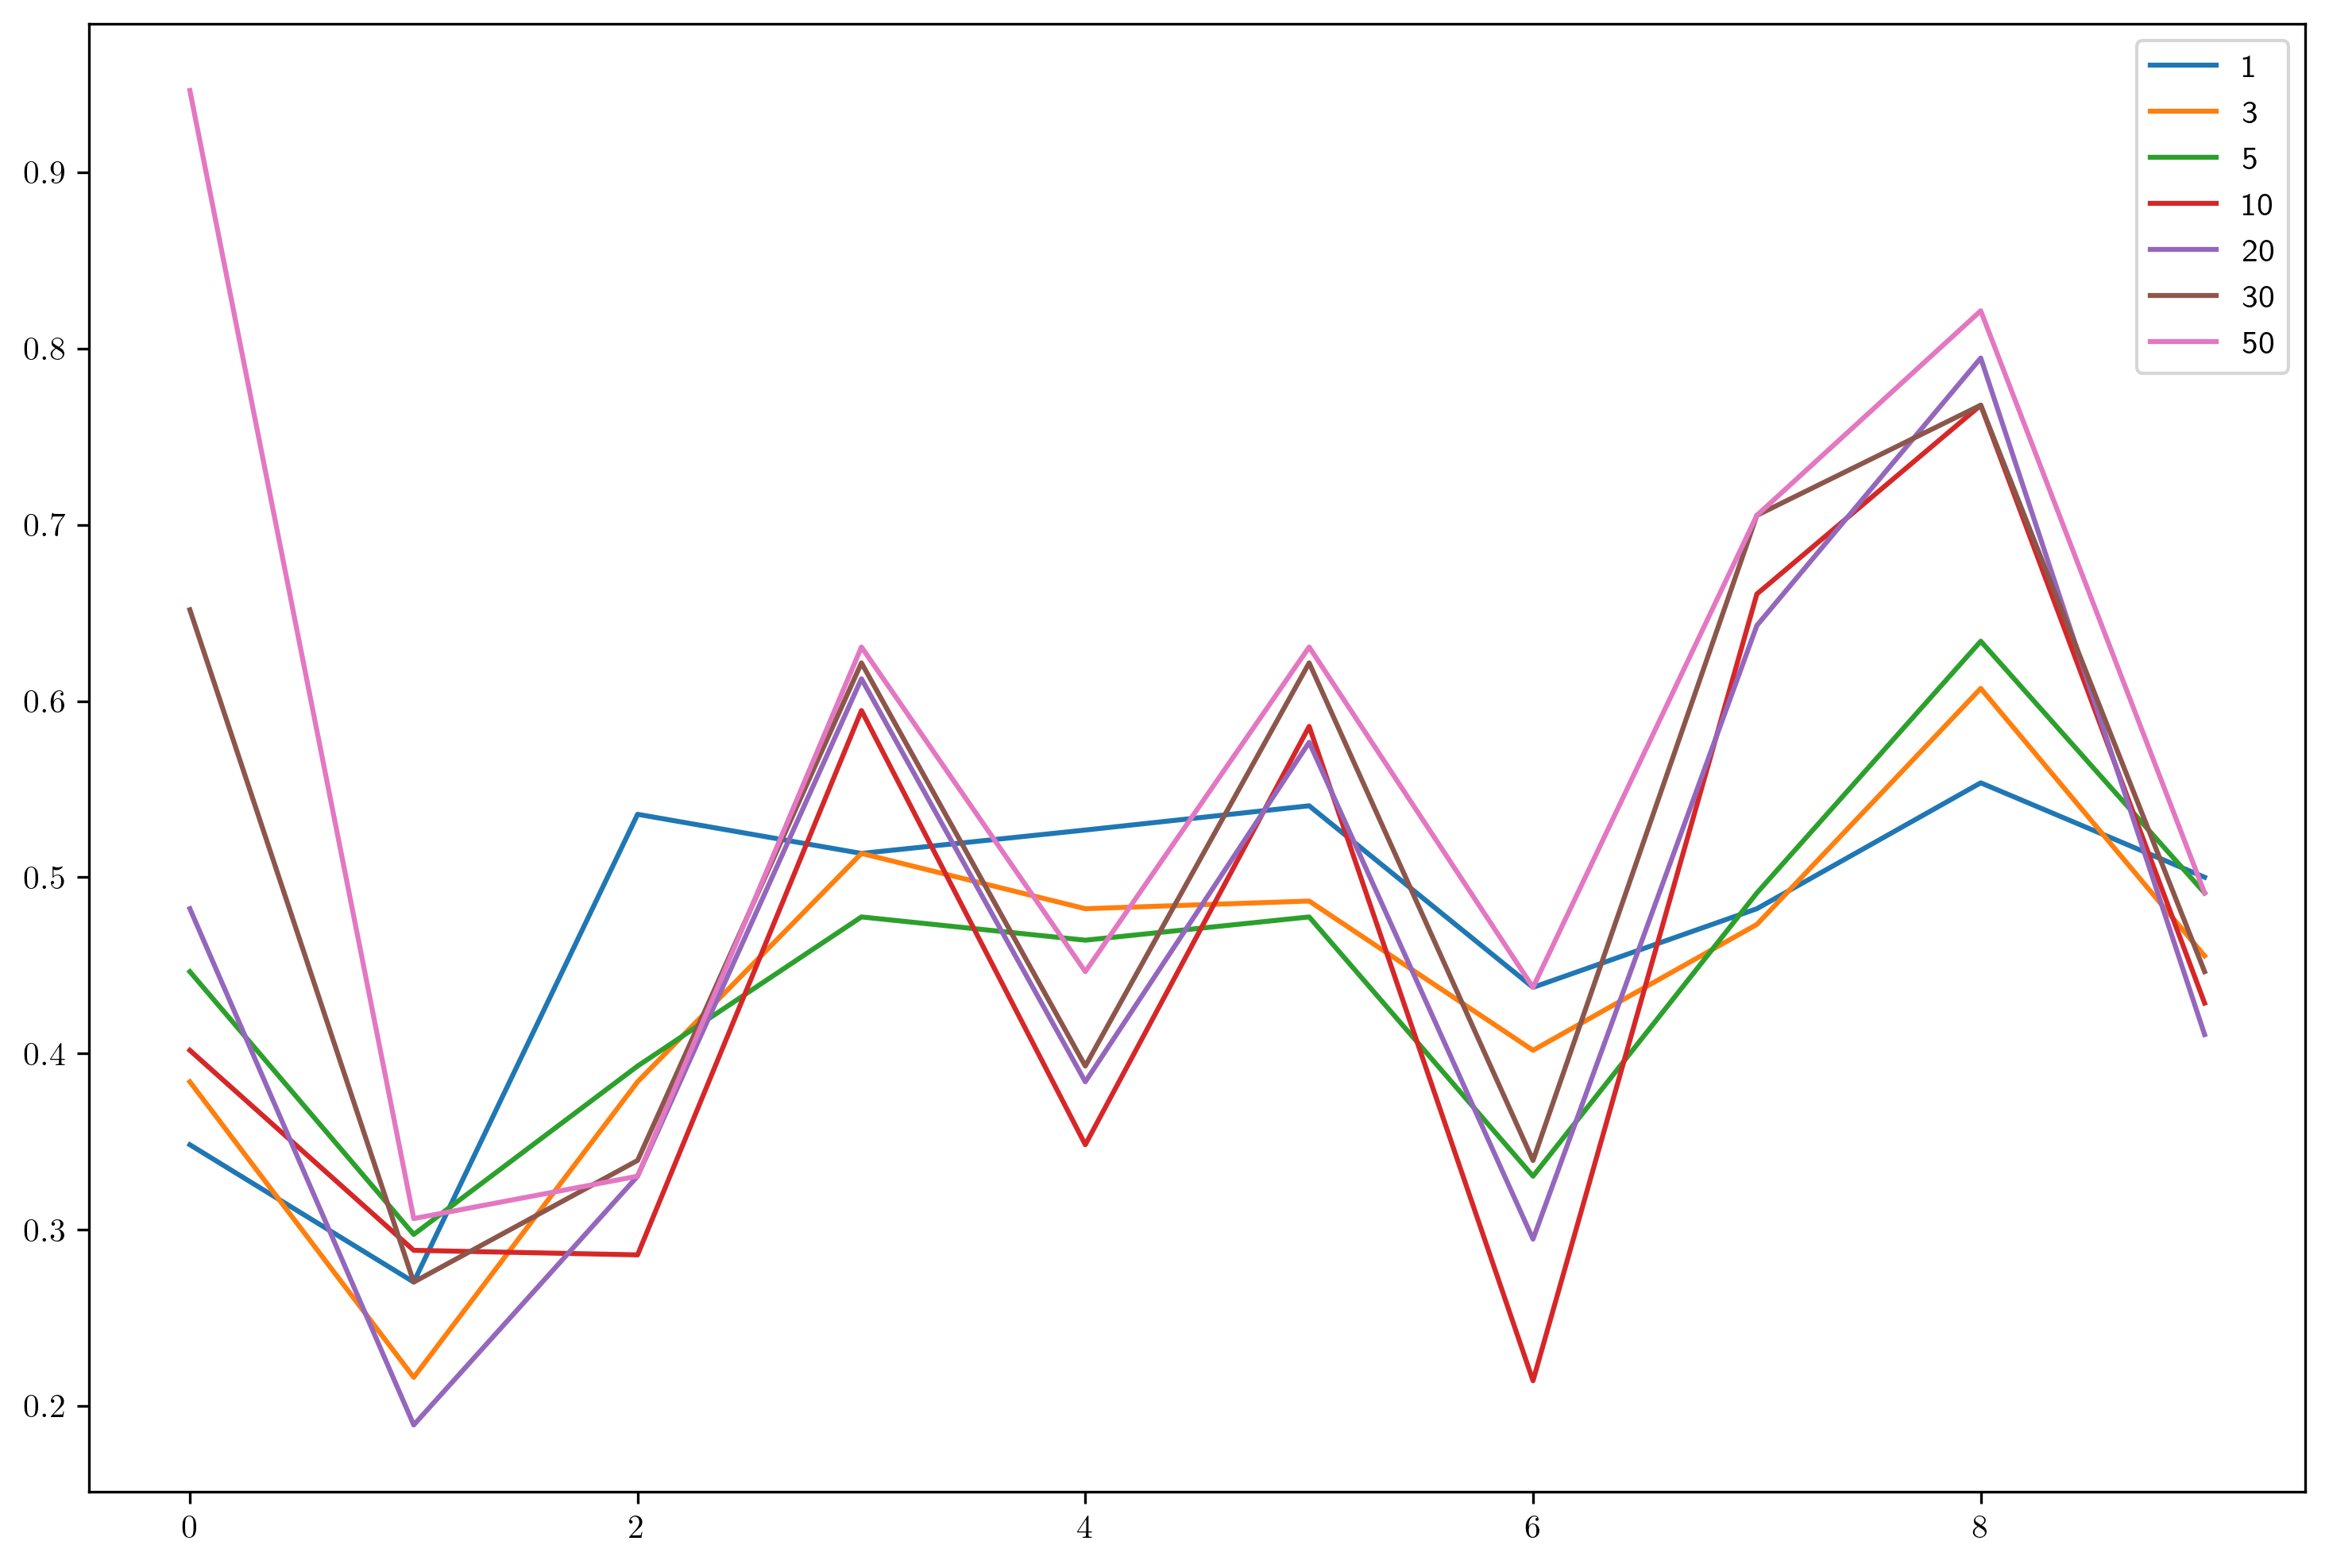

In [6]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((n_folds, len(ks)))

for i, item in enumerate(crossval_splits(full_features, full_labels, n_folds)):
    train_features, train_labels, val_features, val_labels = item
    for j, k in enumerate(ks):
        # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
        classif = KNeighborsClassifier(k)
        classif.fit(train_features.T, train_labels)
        errors[i, j], _ =  mean_err(classif.predict(val_features.T), val_labels)


plt.plot(errors,label=['1','3','5','10','20','30','50'])
plt.legend(loc='best')
plt.show()

(c)

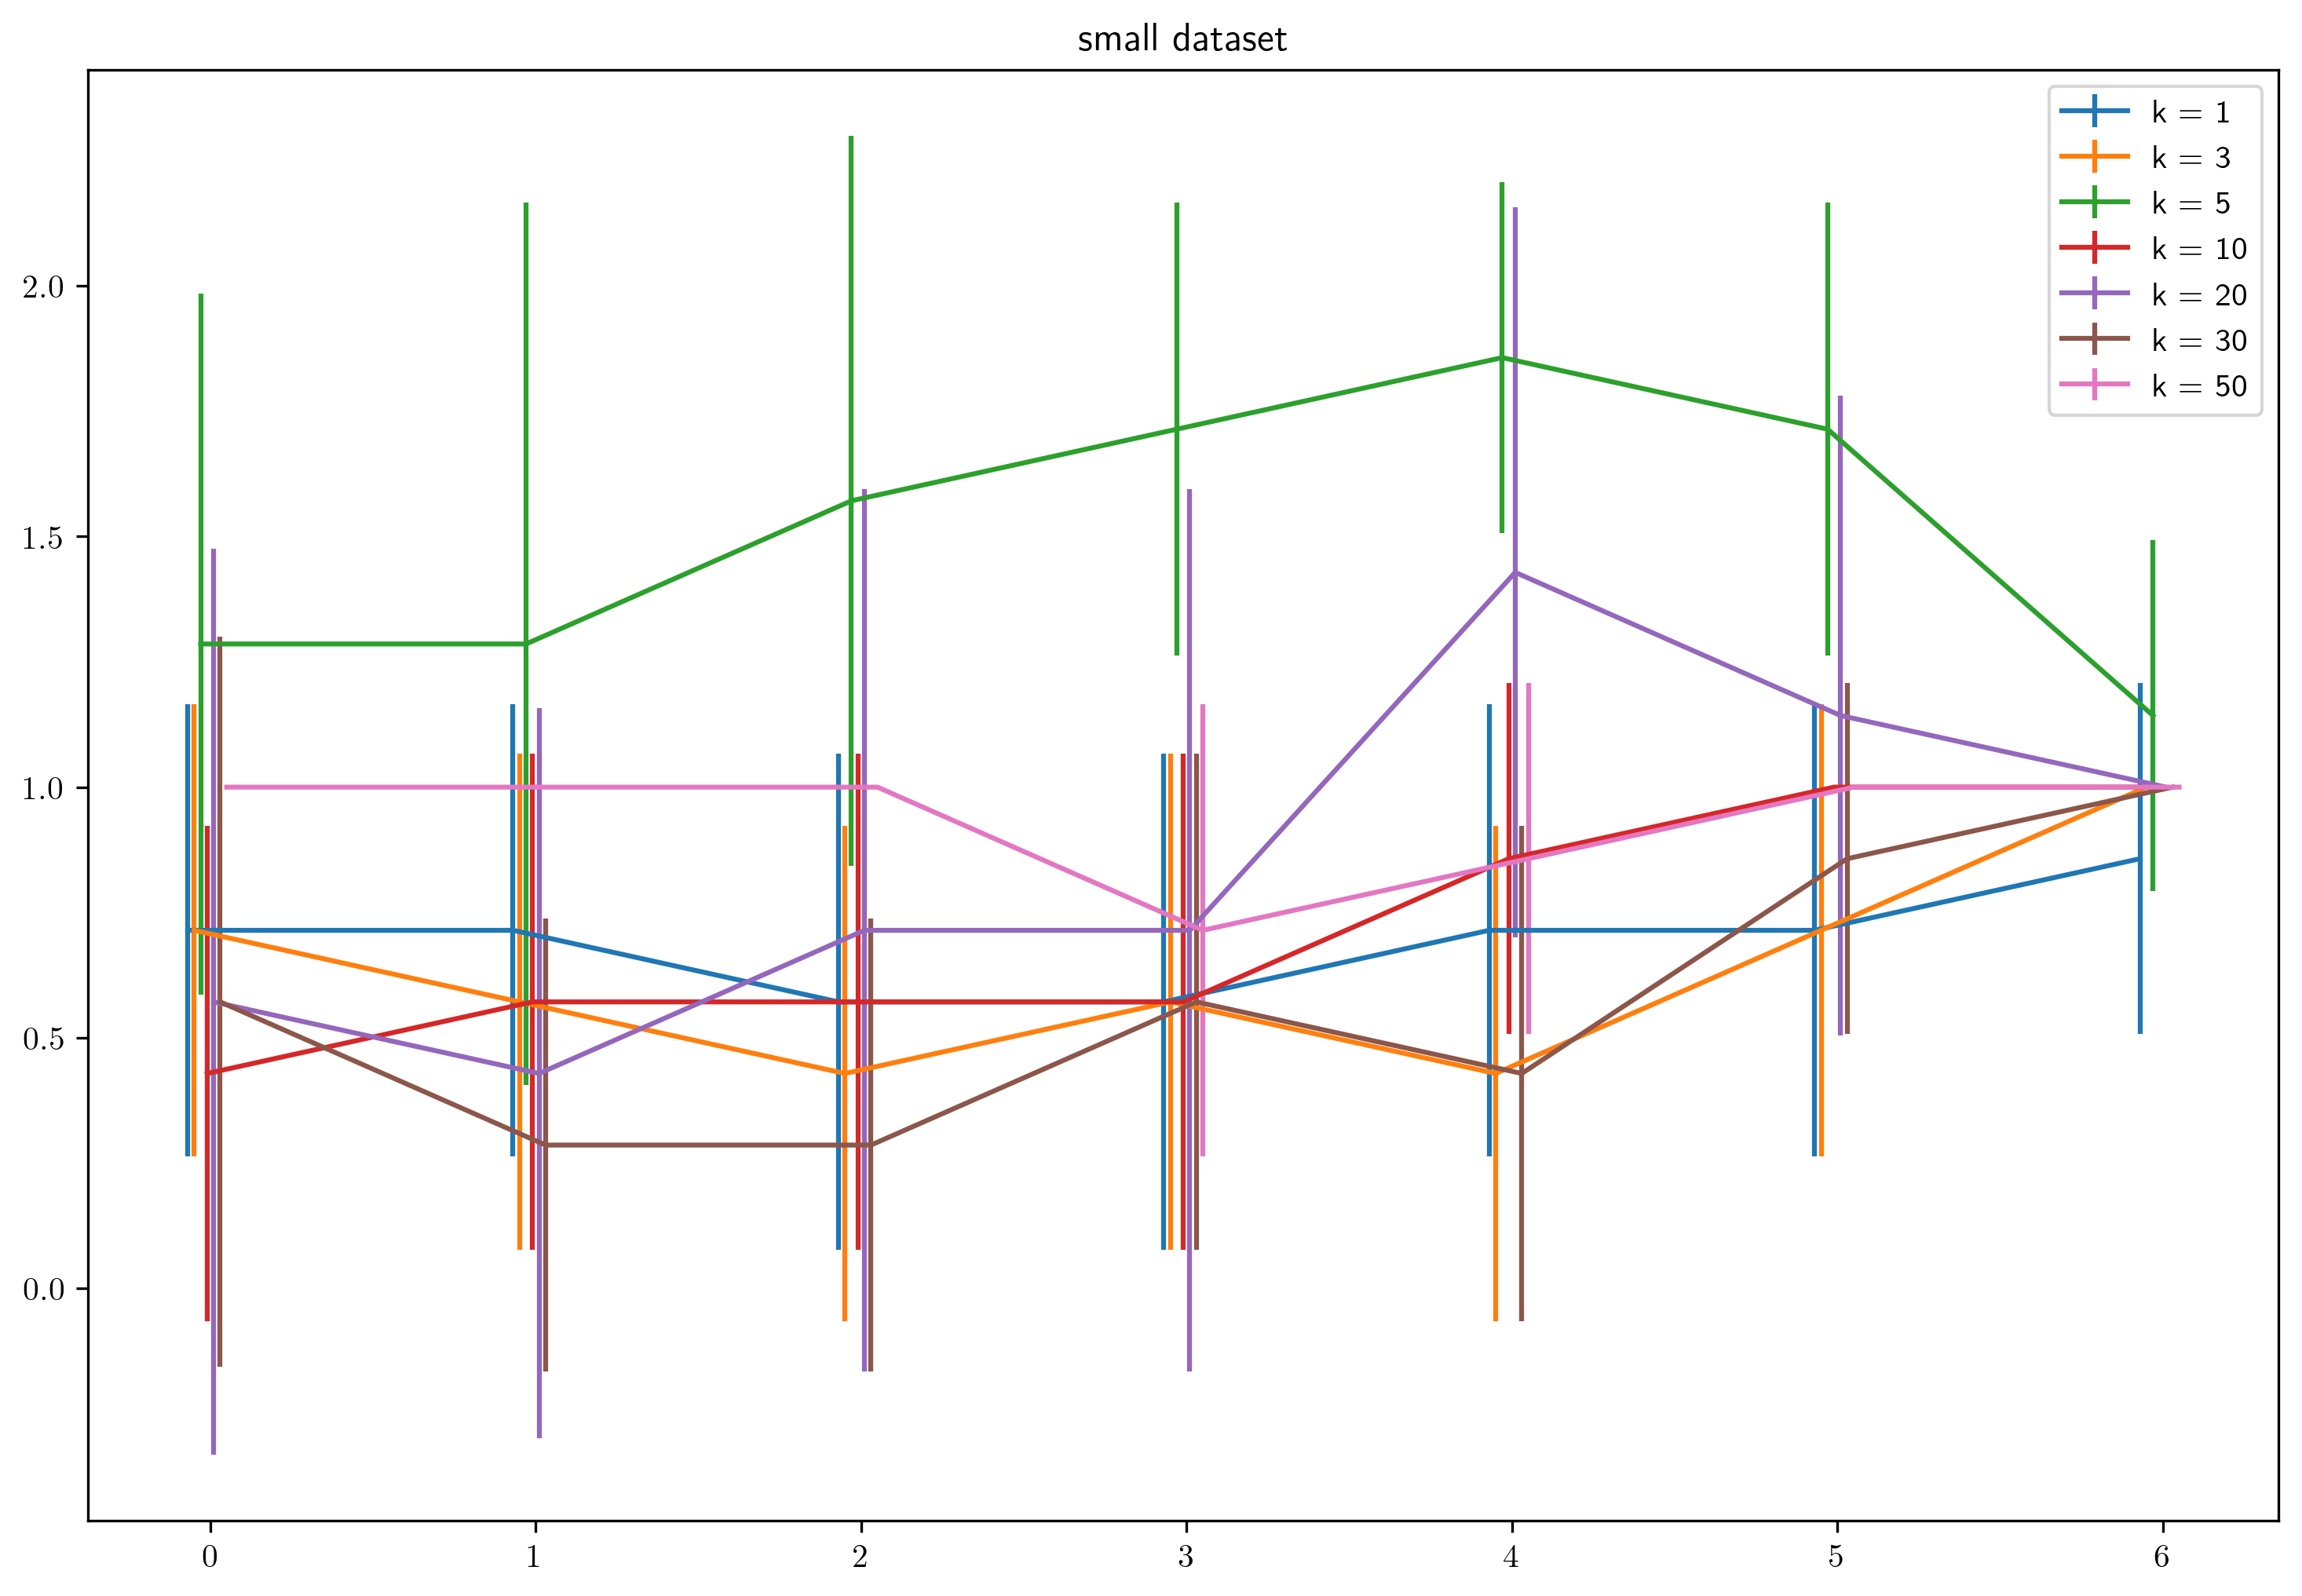

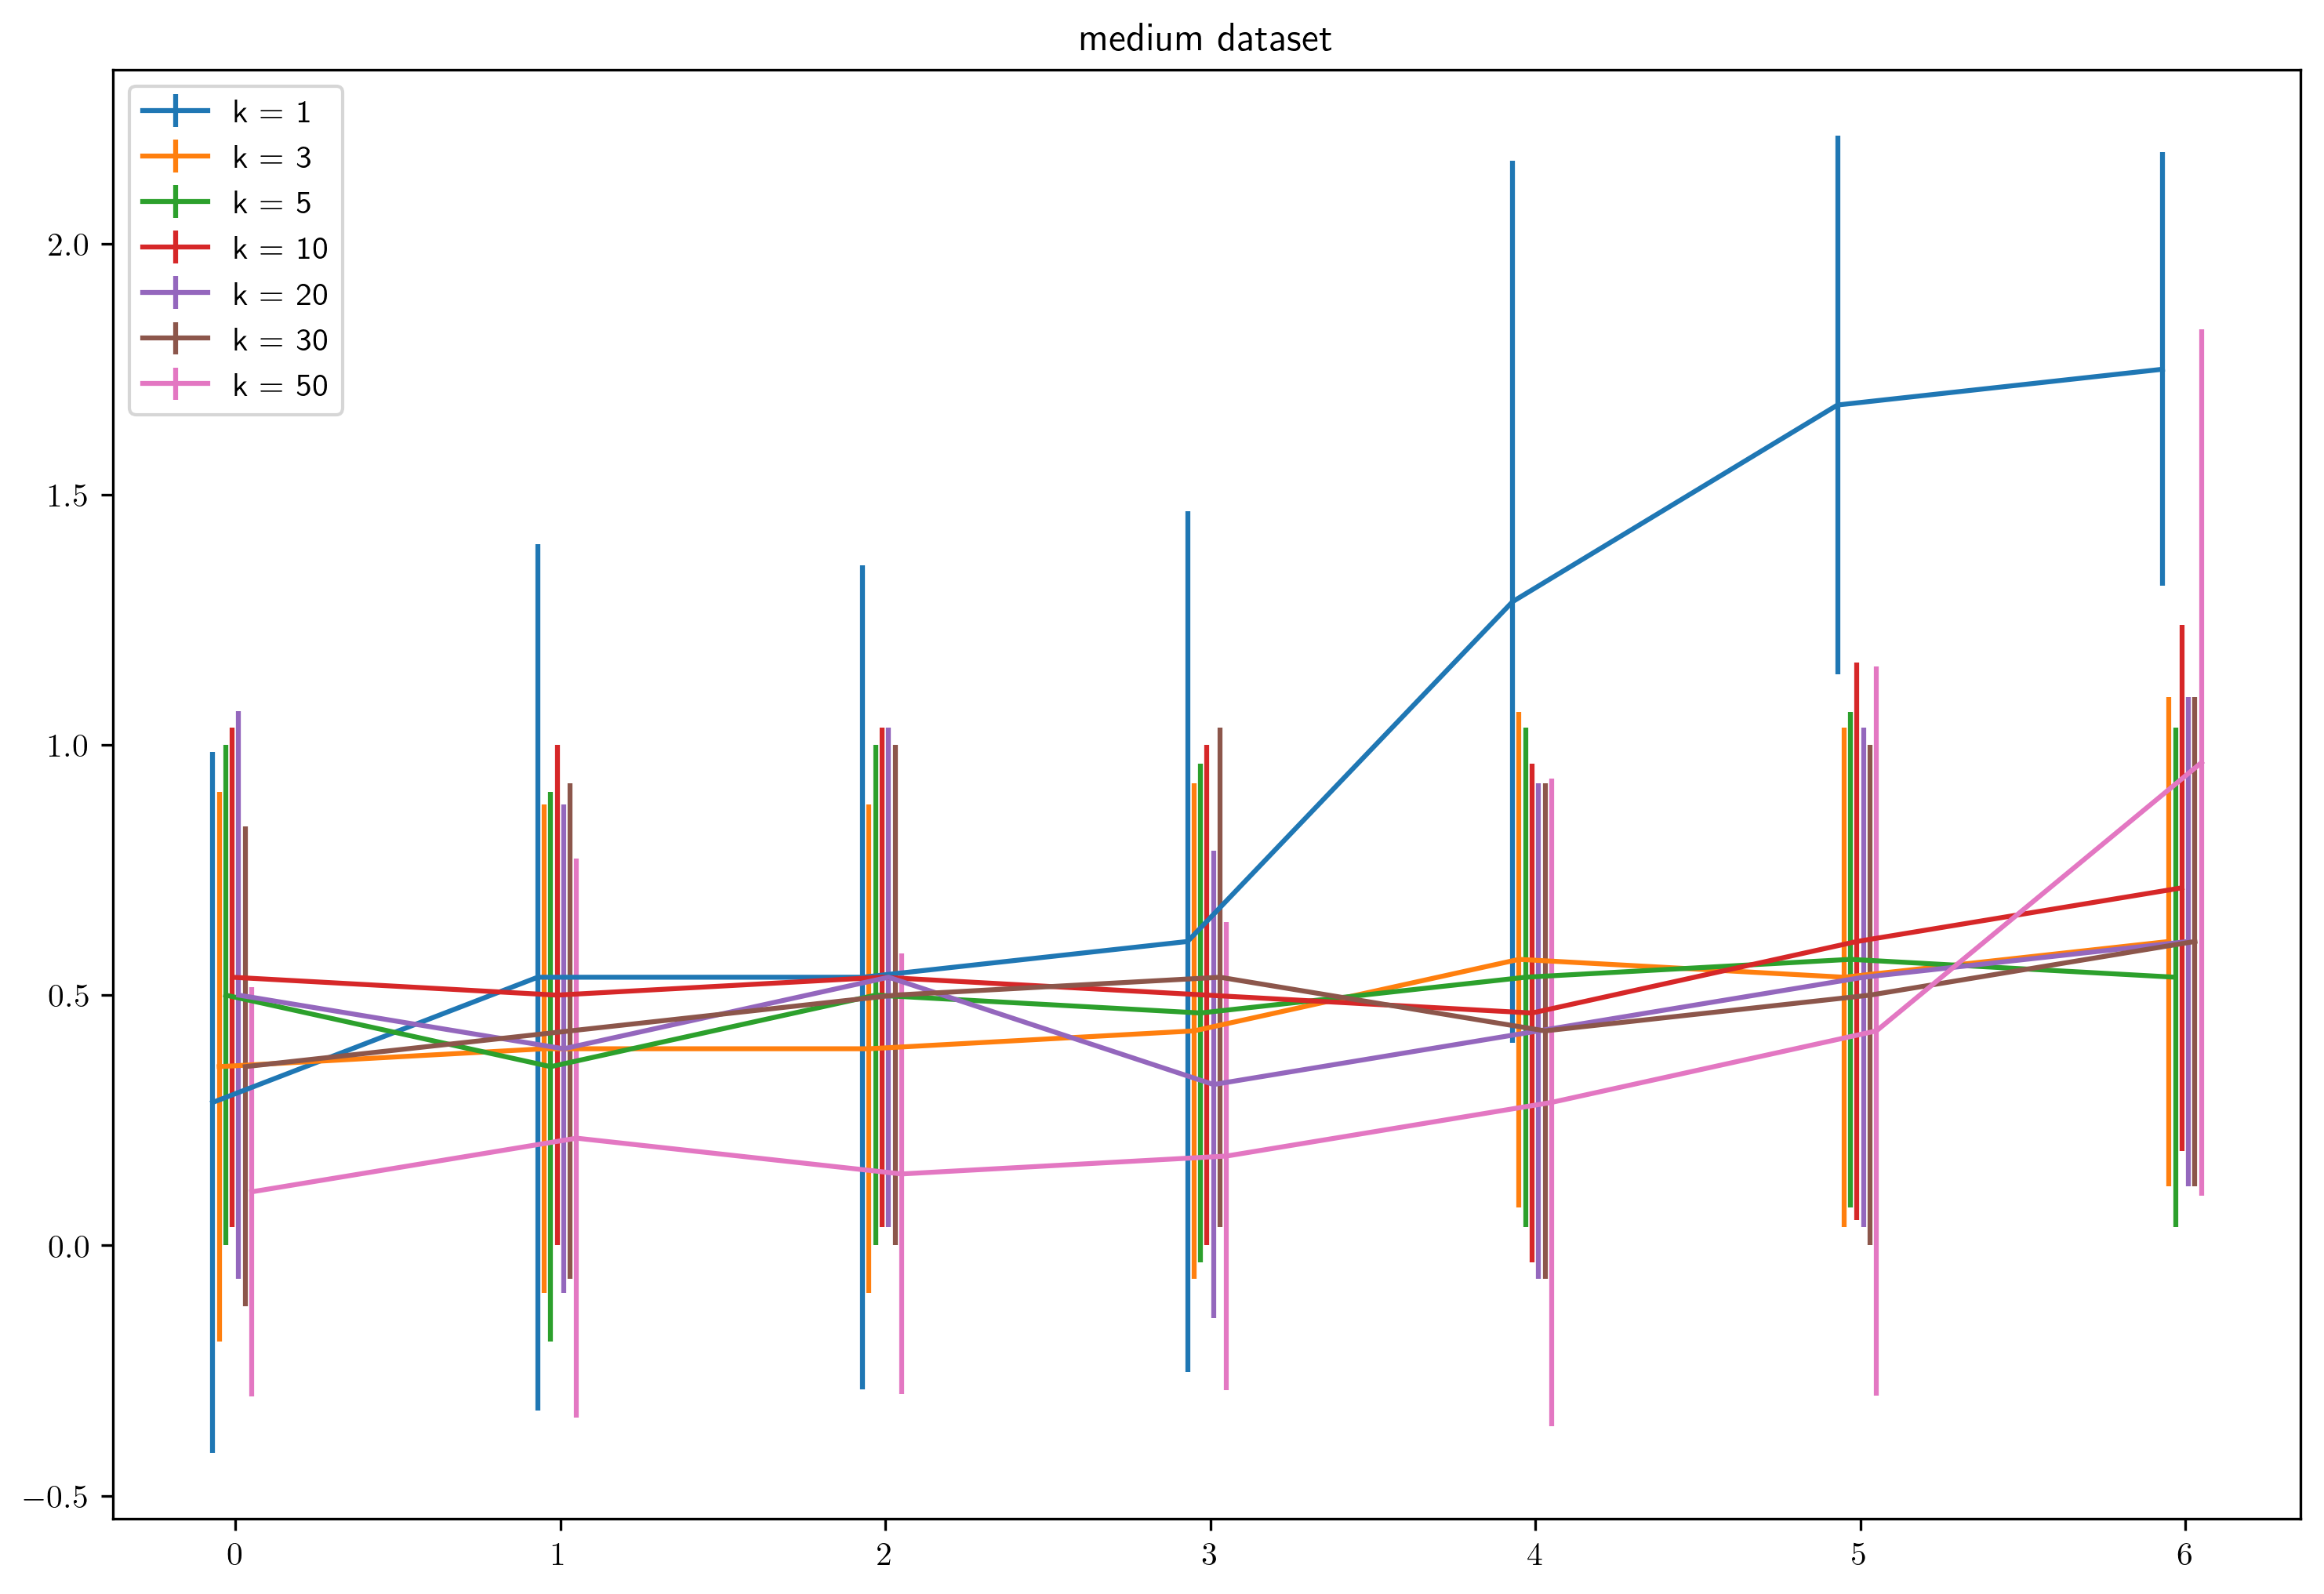

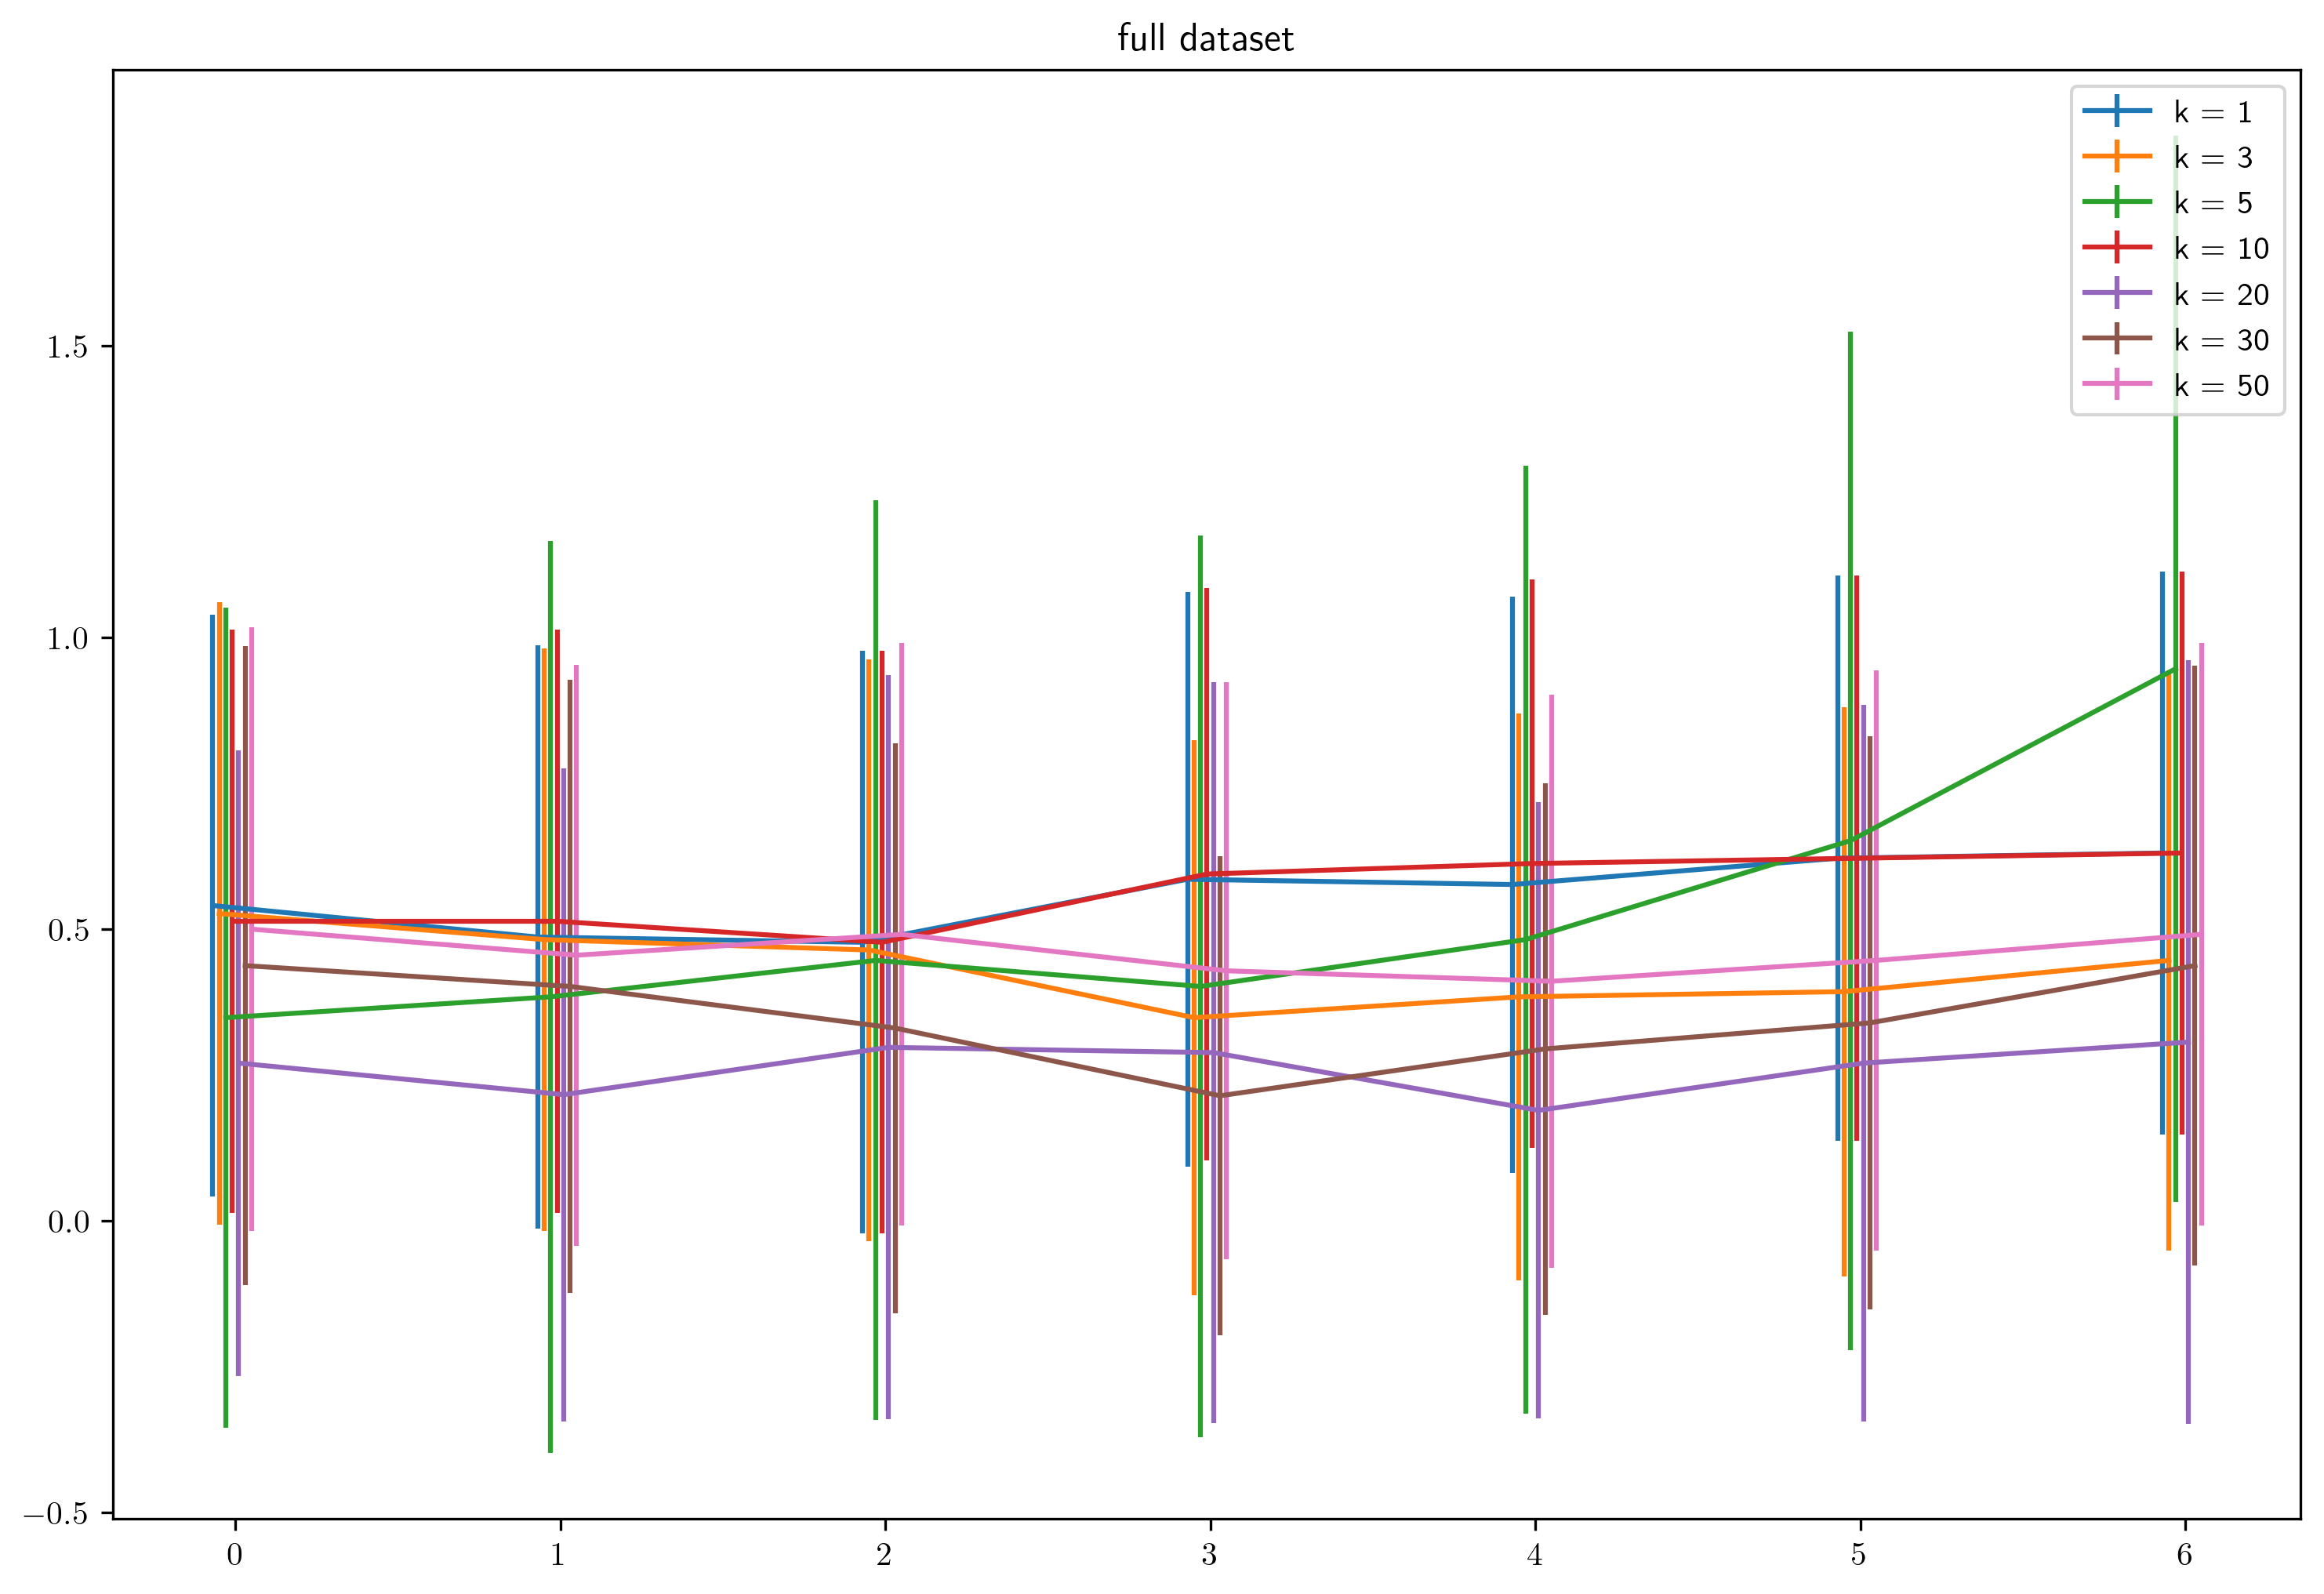

In [7]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((len(dsets), n_folds, len(ks)))
stddevs = np.empty((len(dsets), n_folds, len(ks)))

for i, (features, labels) in enumerate(dsets):
    for j, item in enumerate(crossval_splits(features, labels, n_folds)):
        train_features, train_labels, val_features, val_labels = item
        for l, k in enumerate(ks):
            # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
            classif = KNeighborsClassifier(k)
            classif.fit(train_features.T, train_labels)
            errors[i, j, l], stddevs[i, j, l] =  mean_err(classif.predict(val_features.T), val_labels)
            
for i in range(3):
    for j in range(errors.shape[-1]):
        xoffs = (j-errors.shape[-1]/2)*0.02 #x-offset to be able to see different error bars
        plt.errorbar(np.arange(errors.shape[-1])+xoffs, errors[i,j], yerr=stddevs[i,j],
                     label=f'k = {ks[j]}')
    plt.title(['small', 'medium', 'full'][i] + ' dataset')
    plt.legend(loc='best')
    plt.show()

## 4 Alternative K-Nearest Neighbors
### a) Relation of laid-out procedure to k-NN classification
For $k=1$, the procedure is the same as 1-NN classification. For higher values of k, the predicted classes may differ, if the k-th nearest neighbor of the class which has the minority of points in the set of the k-nearest neighbors is closer to the query point than the k-th nearest neighbor of the other class.
### b) More than two classes
The algorithm easily generalizes:

**(i)** Find the k-th nearest neighbor of the query point for each of the other classes.

**(ii)** Predict that class whose k-th nearest neighbor is closer to the query.

For k=1, this is again the same as the 1-NN classification. For $k\geq 1$, the prediction may differ from that of k-NN again as explained above. The relation thus stays the same.